In [1]:
from PandaSQLite import PandaSQLiteDB
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LogNorm
import matplotlib.ticker as ticker
import matplotlib.patches as patches


In [2]:
db = PandaSQLiteDB("mandel.sql", auto_commit=False)

In [7]:
# for i in [512, 1024, 2048, 4096]:
#     db.import_data(f"{i}", f"{i}.csv")
db.import_data("1thread", "1thread.csv", if_exists="replace")

In [10]:
q = "CREATE TABLE data AS "
for i in [512, 1024, 2048, 4096]:
    q += f"SELECT * FROM \"{i}\" UNION "
q = q[:len(q) - len(" UNION ")]
print(q)
db.execute(q)

CREATE TABLE data AS SELECT * FROM "512" UNION SELECT * FROM "1024" UNION SELECT * FROM "2048" UNION SELECT * FROM "4096"


In [45]:
#db.execute("CREATE TABLE time as SELECT n_threads, size, time_pi*n_iter as time FROM data ORDER BY n_threads, size")
#db.execute(r"CREATE TABLE prefix AS SELECT DISTINCT size, '$' || size || ' \\times ' || size || '$' as prefix FROM data")
db.delete_table("prefix")
db.execute(r"CREATE TABLE prefix AS SELECT DISTINCT size, '$' || size || ' \times ' || size || '$' as prefix FROM data ORDER BY size")
# db.query(r"SELECT DISTINCT size, '$' || size || ' \\times ' || size || '$' as prefix FROM data")


In [13]:
db.query("SELECT * FROM time WHERE n_threads = 1")

n_threads  size          time
0          1   512  7.509101e+05
1          1  1024  3.005486e+06
2          1  2048  1.200194e+07
3          1  4096  4.799171e+07

In [39]:
db.query("SELECT * FROM speedup NATURAL JOIN prefix")

Threads  Size    Speedup               prefix
0         1   512   1.000000    $512 \\times 512$
1         1  1024   1.000000  $1024 \\times 1024$
2         1  2048   1.000000  $2048 \\times 2048$
3         1  4096   1.000000  $4096 \\times 4096$
4         2   512   1.955282    $512 \\times 512$
5         2  1024   1.982681  $1024 \\times 1024$
6         2  2048   2.006496  $2048 \\times 2048$
7         2  4096   2.010380  $4096 \\times 4096$
8         4   512   2.022107    $512 \\times 512$
9         4  1024   2.067080  $1024 \\times 1024$
10        4  2048   2.076899  $2048 \\times 2048$
11        4  4096   2.082533  $4096 \\times 4096$
12        8   512   3.000347    $512 \\times 512$
13        8  1024   3.047454  $1024 \\times 1024$
14        8  2048   3.099038  $2048 \\times 2048$
15        8  4096   3.108487  $4096 \\times 4096$
16       16   512   5.100590    $512 \\times 512$
17       16  1024   5.178541  $1024 \\times 1024$
18       16  2048   5.440406  $2048 \\times 2048$
19       16  4096   5.480148  $4096 \\times 4096$
20       32   512   8.452406    $512 \\times 512$
21       32  1024  10.007181  $1024 \\times 1024$
22       32  2048  10.276323  $2048 \\times 2048$
23       32  4096  10.531245  $4096 \\times 4096$
24       64   512   3.656789    $512 \\times 512$
25       64  1024  11.616179  $1024 \\times 1024$
26       64  2048  15.997736  $2048 \\times 2048$
27       64  4096  20.131156  $4096 \\times 4096$

In [33]:
q = "CREATE TABLE speedup AS "
for index, row in db.query("SELECT * FROM time WHERE n_threads = 1").iterrows():
    size = row['size']
    time = row['time']
    q += f"SELECT n_threads as Threads, size as Size, {time}/time as Speedup FROM time WHERE size = {size} UNION "
q = q[:len(q) - len(" UNION ")]
print(q)

db.execute(q)

CREATE TABLE speedup AS SELECT n_threads as Threads, size as Size, 750910.128072/time as Speedup FROM time WHERE size = 512.0 UNION SELECT n_threads as Threads, size as Size, 3005486.2981700003/time as Speedup FROM time WHERE size = 1024.0 UNION SELECT n_threads as Threads, size as Size, 12001936.678326/time as Speedup FROM time WHERE size = 2048.0 UNION SELECT n_threads as Threads, size as Size, 47991707.31368/time as Speedup FROM time WHERE size = 4096.0


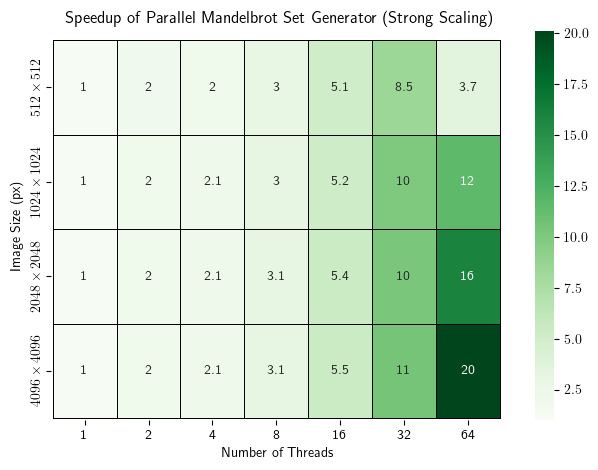

In [3]:
# Create the heatmap using Seaborn's heatmap function
plt.rcParams['text.usetex'] = True
df = db.query("SELECT Threads, Speedup, size FROM speedup NATURAL JOIN prefix")
cmap_colors = sns.color_palette("Greens", n_colors=200).as_hex()
heatmap_data = df.pivot(index='Size', columns='Threads', values='Speedup')
ax = sns.heatmap(heatmap_data, cmap=cmap_colors, annot=True, linewidth=.5, linecolor='black')


# Add custom labels to y-axis
yticklabels = [i for i in db.query("SELECT prefix FROM prefix")["prefix"]] # example custom labels
ax.set_yticklabels(yticklabels)

# Add labels and title
plt.xlabel('Number of Threads')
plt.ylabel('Image Size (px)')
plt.title("Speedup of Parallel Mandelbrot Set Generator (Strong Scaling)")

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.02, top - 0.1)

left, right = ax.get_xlim()
ax.set_xlim(left-0.02, right + 0.1)
plt.tight_layout()
plt.savefig(f"quicksort_strong_heatmap.pdf")



In [ ]:
# Create the heatmap using Seaborn's heatmap function
plt.rcParams['text.usetex'] = True
df = db.query("SELECT n_threads as Threads, time_pp as time, size FROM data NATURAL JOIN prefix")
cmap_colors = sns.color_palette("Greens", n_colors=200).as_hex()
heatmap_data = df.pivot(index='Size', columns='Threads', values='Speedup')
ax = sns.heatmap(heatmap_data, cmap=cmap_colors, annot=True, linewidth=.5, linecolor='black')


# Add custom labels to y-axis
yticklabels = [i for i in db.query("SELECT prefix FROM prefix")["prefix"]] # example custom labels
ax.set_yticklabels(yticklabels)

# Add labels and title
plt.xlabel('Number of Threads')
plt.ylabel('Image Size (px)')
plt.title("Speedup of Parallel Mandelbrot Set Generator (Strong Scaling)")

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.02, top - 0.1)

left, right = ax.get_xlim()
ax.set_xlim(left-0.02, right + 0.1)
plt.tight_layout()
plt.savefig(f"quicksort_strong_heatmap.svg", format="svg")

DatabaseError: Execution failed on sql 'SELECT size as Size, time/11779.4 as Time, n_threads as Threads FROM weak': no such table: weak

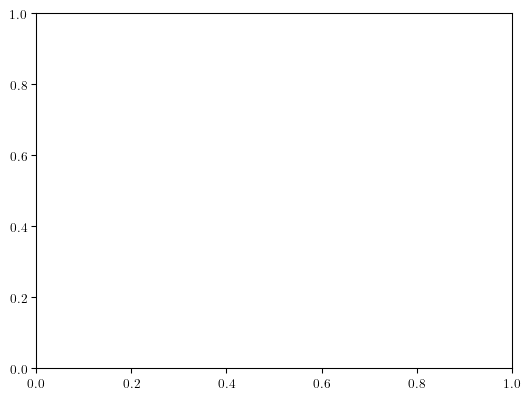

In [4]:

f, ax = plt.subplots(dpi=96)
plt.rcParams['text.usetex'] = True
sns.set_style("ticks")
pal = sns.color_palette("bright")
colors = pal.as_hex()
colors[5] = "#57b3e9"

sns.lineplot(
    data=db.query("SELECT size as Size, time/11779.4 as Time, n_threads as Threads FROM weak"),
    x="Threads",
    y="Time",
    linewidth=1.8,
    color="red",
    # hue="Algorithm",
    # style="Algorithm",
    marker="X",
    markersize=8,
    #
    errorbar=None,
    ax=ax
).set_title("Weak scaling of parallel-quicksort calculation.")

plt.grid(alpha=0.8)
#ax.set_xscale('log', base=2)
#sns.move_legend(ax, "upper left")
#plt.rcParams["font.serif"] = "Times New Roman"
ax.set(ylabel=r'Normalized execution time', xlabel=r'Number of iterations')
#plt.xticks([2**i for i in range(1,7)], [f"${2**i}$\n $N={2**i}\\times 10^6$" for i in range(1,7)])
ax.set_xticks([2**i for i in range(7)], [f"{2**i}$\\times 10^6$" for i in range(7)], rotation="vertical")
top_ax = ax.twiny()
top_ax.set_xlim(ax.get_xlim())
top_ax.set_xticks([2**i for i in range(7)])
top_ax.set(xlabel=r'Number of threads')

ax.tick_params(axis='x', which='major', labelsize=9)
top_ax.tick_params(axis='x', which='major', labelsize=10)
plt.tight_layout()

#plt.savefig(f"par_pi_weak_scaling.svg", format="svg")


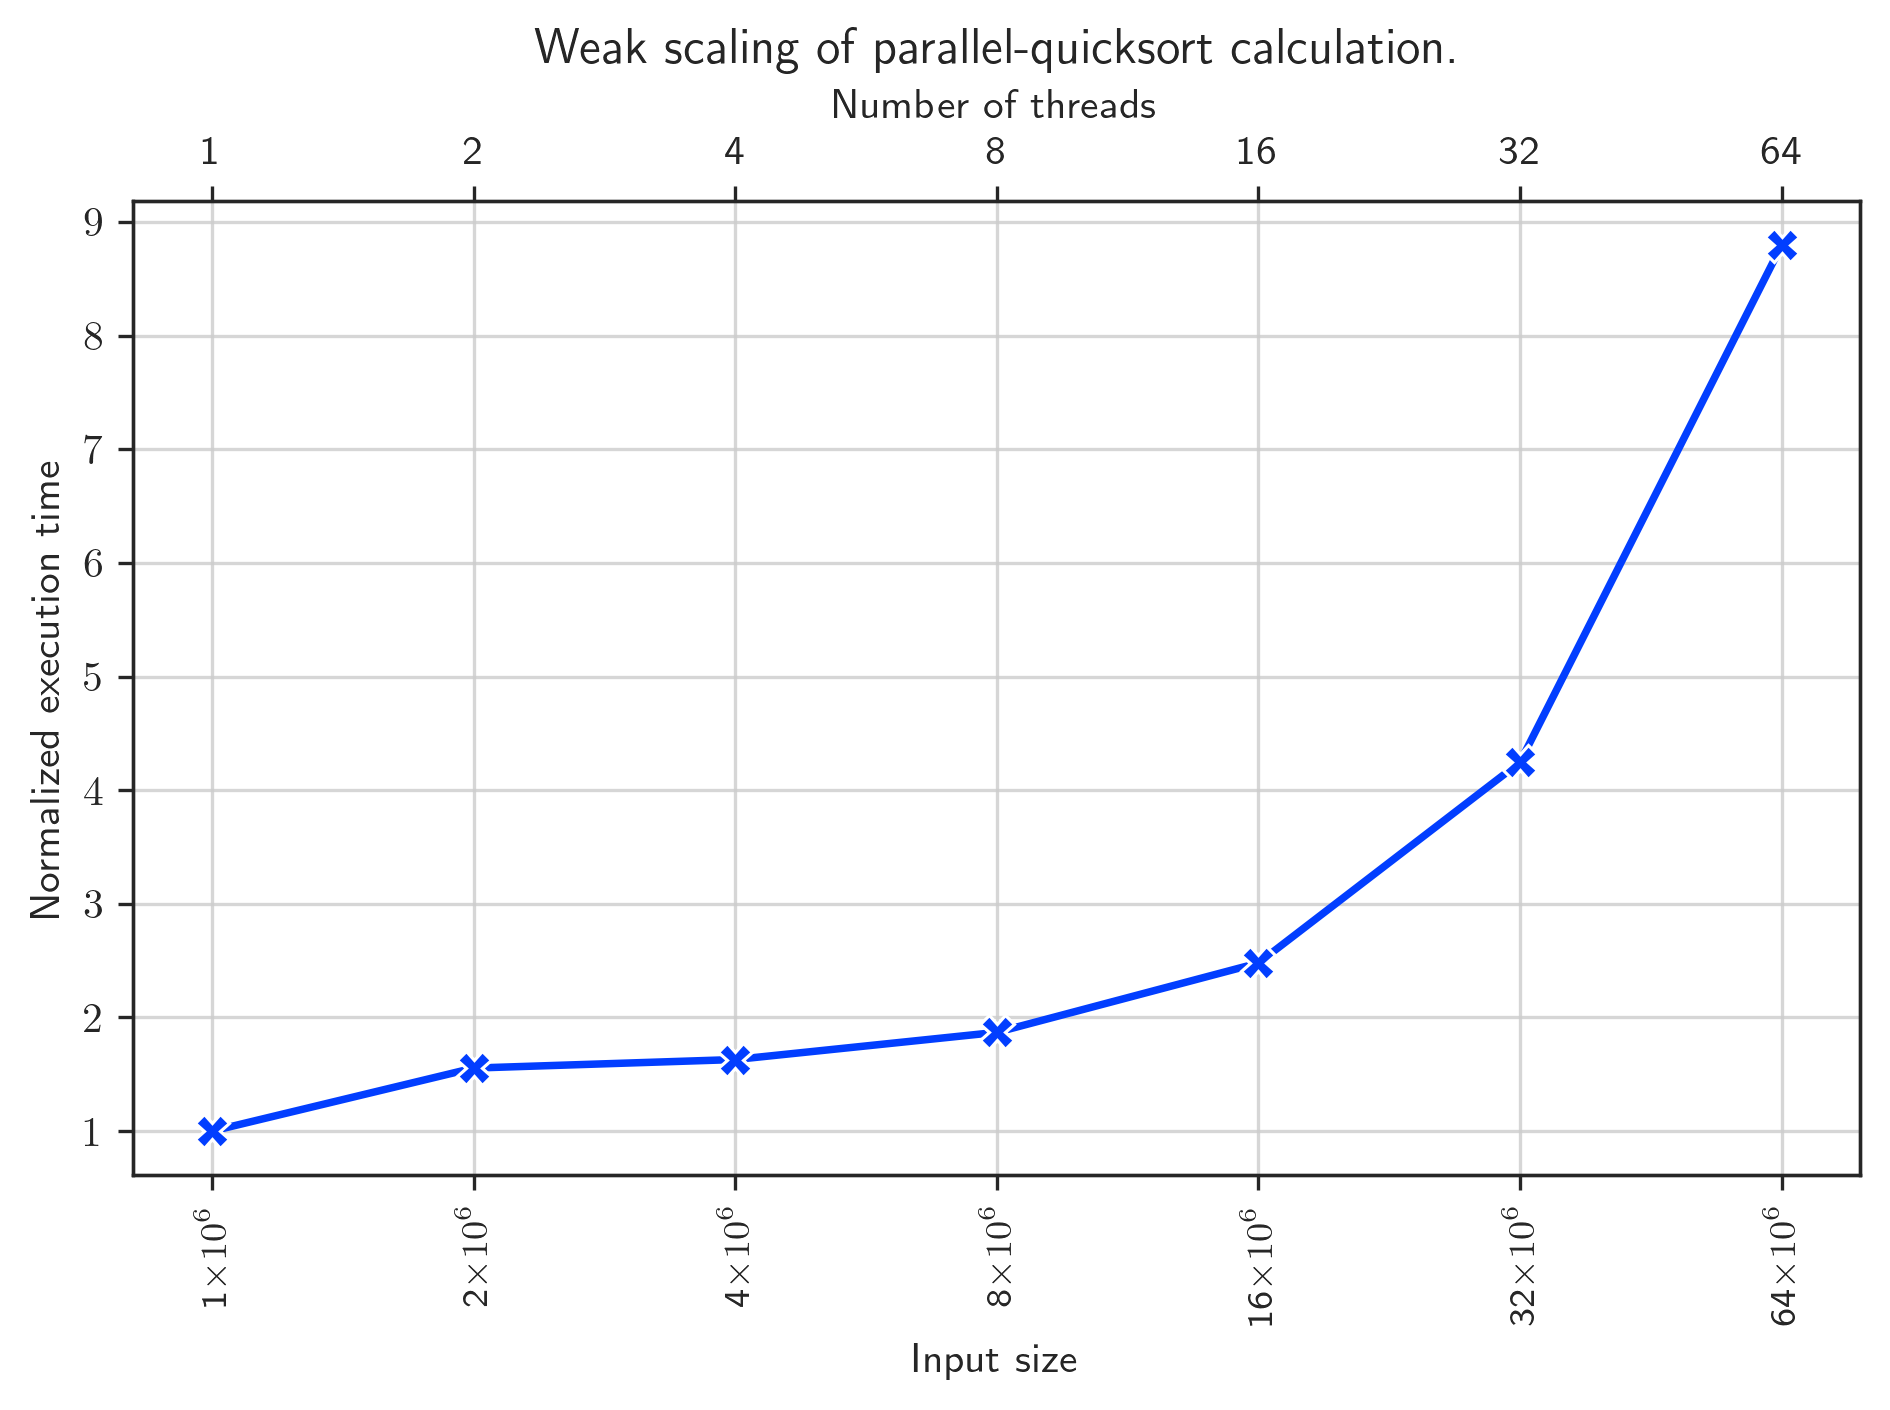

In [98]:

f, ax = plt.subplots(dpi=300)
plt.rcParams['text.usetex'] = True
sns.set_style("ticks")
pal = sns.color_palette("bright")
colors = pal.as_hex()
colors[5] = "#57b3e9"

sns.lineplot(
    data=db.query("SELECT size as Size, time/11779.4 as Time, n_threads as Threads FROM weak"),
    x="Threads",
    y="Time",
    linewidth=1.8,
    color=colors[0],
    # hue="Algorithm",
    # style="Algorithm",
    marker="X",
    markersize=8,
    errorbar=None,
    ax=ax
).set_title("Weak scaling of parallel-quicksort calculation.")

plt.grid(alpha=0.8)
ax.set_xscale('log', base=2)
#sns.move_legend(ax, "upper left")
#plt.rcParams["font.serif"] = "Times New Roman"
ax.set(ylabel=r'Normalized execution time', xlabel=r'Input size')
#plt.xticks([2**i for i in range(1,7)], [f"${2**i}$\n $N={2**i}\\times 10^6$" for i in range(1,7)])
top_ax = ax.twiny()
top_ax.set_xscale('log', base=2)
ax.set_xticks([2**i for i in range(7)], [f"{2**i}$\\times 10^6$" for i in range(7)], rotation="vertical")
top_ax.set_xlim(ax.get_xlim())
top_ax.set_xticks([2**i for i in range(7)],  [f"{2**i}" for i in range(7)])
top_ax.set(xlabel=r'Number of threads')


ax.tick_params(axis='x', which='major', labelsize=9)
top_ax.tick_params(axis='x', which='major', labelsize=10)
plt.tight_layout()

plt.savefig(f"par_quicksort_weak_scaling.svg", format="svg")


In [74]:

db.commit()

In [75]:
db.get_table("weak")

n_threads       size      time
0          1   10000000   11779.4
1          2   20000000   18311.8
2          4   40000000   19198.4
3          8   80000000   22016.8
4         16  160000000   29199.6
5         32  320000000   50009.7
6         64  640000000  103586.0